In [18]:
import os
import glob
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
from pathlib import Path
from typing import Optional, List, Tuple, Dict
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist
from scipy import stats

In [8]:
def plot_top_genes_across_k(output_dir, name, k_range, density_threshold=0.01, top_pct=0.01,
                            xtick_step=10):

    all_top_genes = {}
    all_gene_sets = set()

    for k in k_range:
        spectra_file = f"{output_dir}/{name}.gene_spectra_score.k_{k}.dt_{str(density_threshold).replace('.', '_')}.txt"
        spectra_df = pd.read_csv(spectra_file, sep='\t', index_col=0)

        n_genes = spectra_df.shape[1]
        n_top_genes = max(1, int(n_genes * top_pct))

        for gep_name, row in spectra_df.iterrows():
            gep_id = f"k{k}_{gep_name}"
            top_genes = row.nlargest(n_top_genes).index.tolist()
            all_top_genes[gep_id] = top_genes
            all_gene_sets.update(top_genes)

    all_genes_sorted = sorted(all_gene_sets)
    binary_matrix = pd.DataFrame(
        0,
        index=list(all_top_genes.keys()),
        columns=all_genes_sorted,
        dtype=int,
    )

    for gep, genes in all_top_genes.items():
        binary_matrix.loc[gep, genes] = 1

    if binary_matrix.shape[1] > 1:
        gene_linkage = linkage(binary_matrix.T, method='average', metric='euclidean')
        gene_order = dendrogram(gene_linkage, no_plot=True)['leaves']
        binary_matrix = binary_matrix.iloc[:, gene_order]

    fig_width = max(20, len(binary_matrix.columns) / 10)
    fig, ax = plt.subplots(figsize=(fig_width, 24))  

    sns.heatmap(
        binary_matrix,
        cmap='YlOrRd',
        cbar_kws={'label': f'Gene in top {top_pct*100:.1f}%'},
        xticklabels=True,
        yticklabels=binary_matrix.index,
        ax=ax
    )

    ticks = ax.get_xticks()
    ax.set_xticks(ticks[::xtick_step])
    labels = binary_matrix.columns[::xtick_step]
    ax.set_xticklabels(labels, rotation=60, fontsize=18)

    ax.set_xlabel("Genes", fontsize=20)
    ax.set_ylabel("GEP (includes K)", fontsize=20)
    ax.set_title(f"Top {top_pct*100:.1f}% Genes for each GEP across K values", fontsize=14)

    plt.tight_layout()

    return fig, binary_matrix


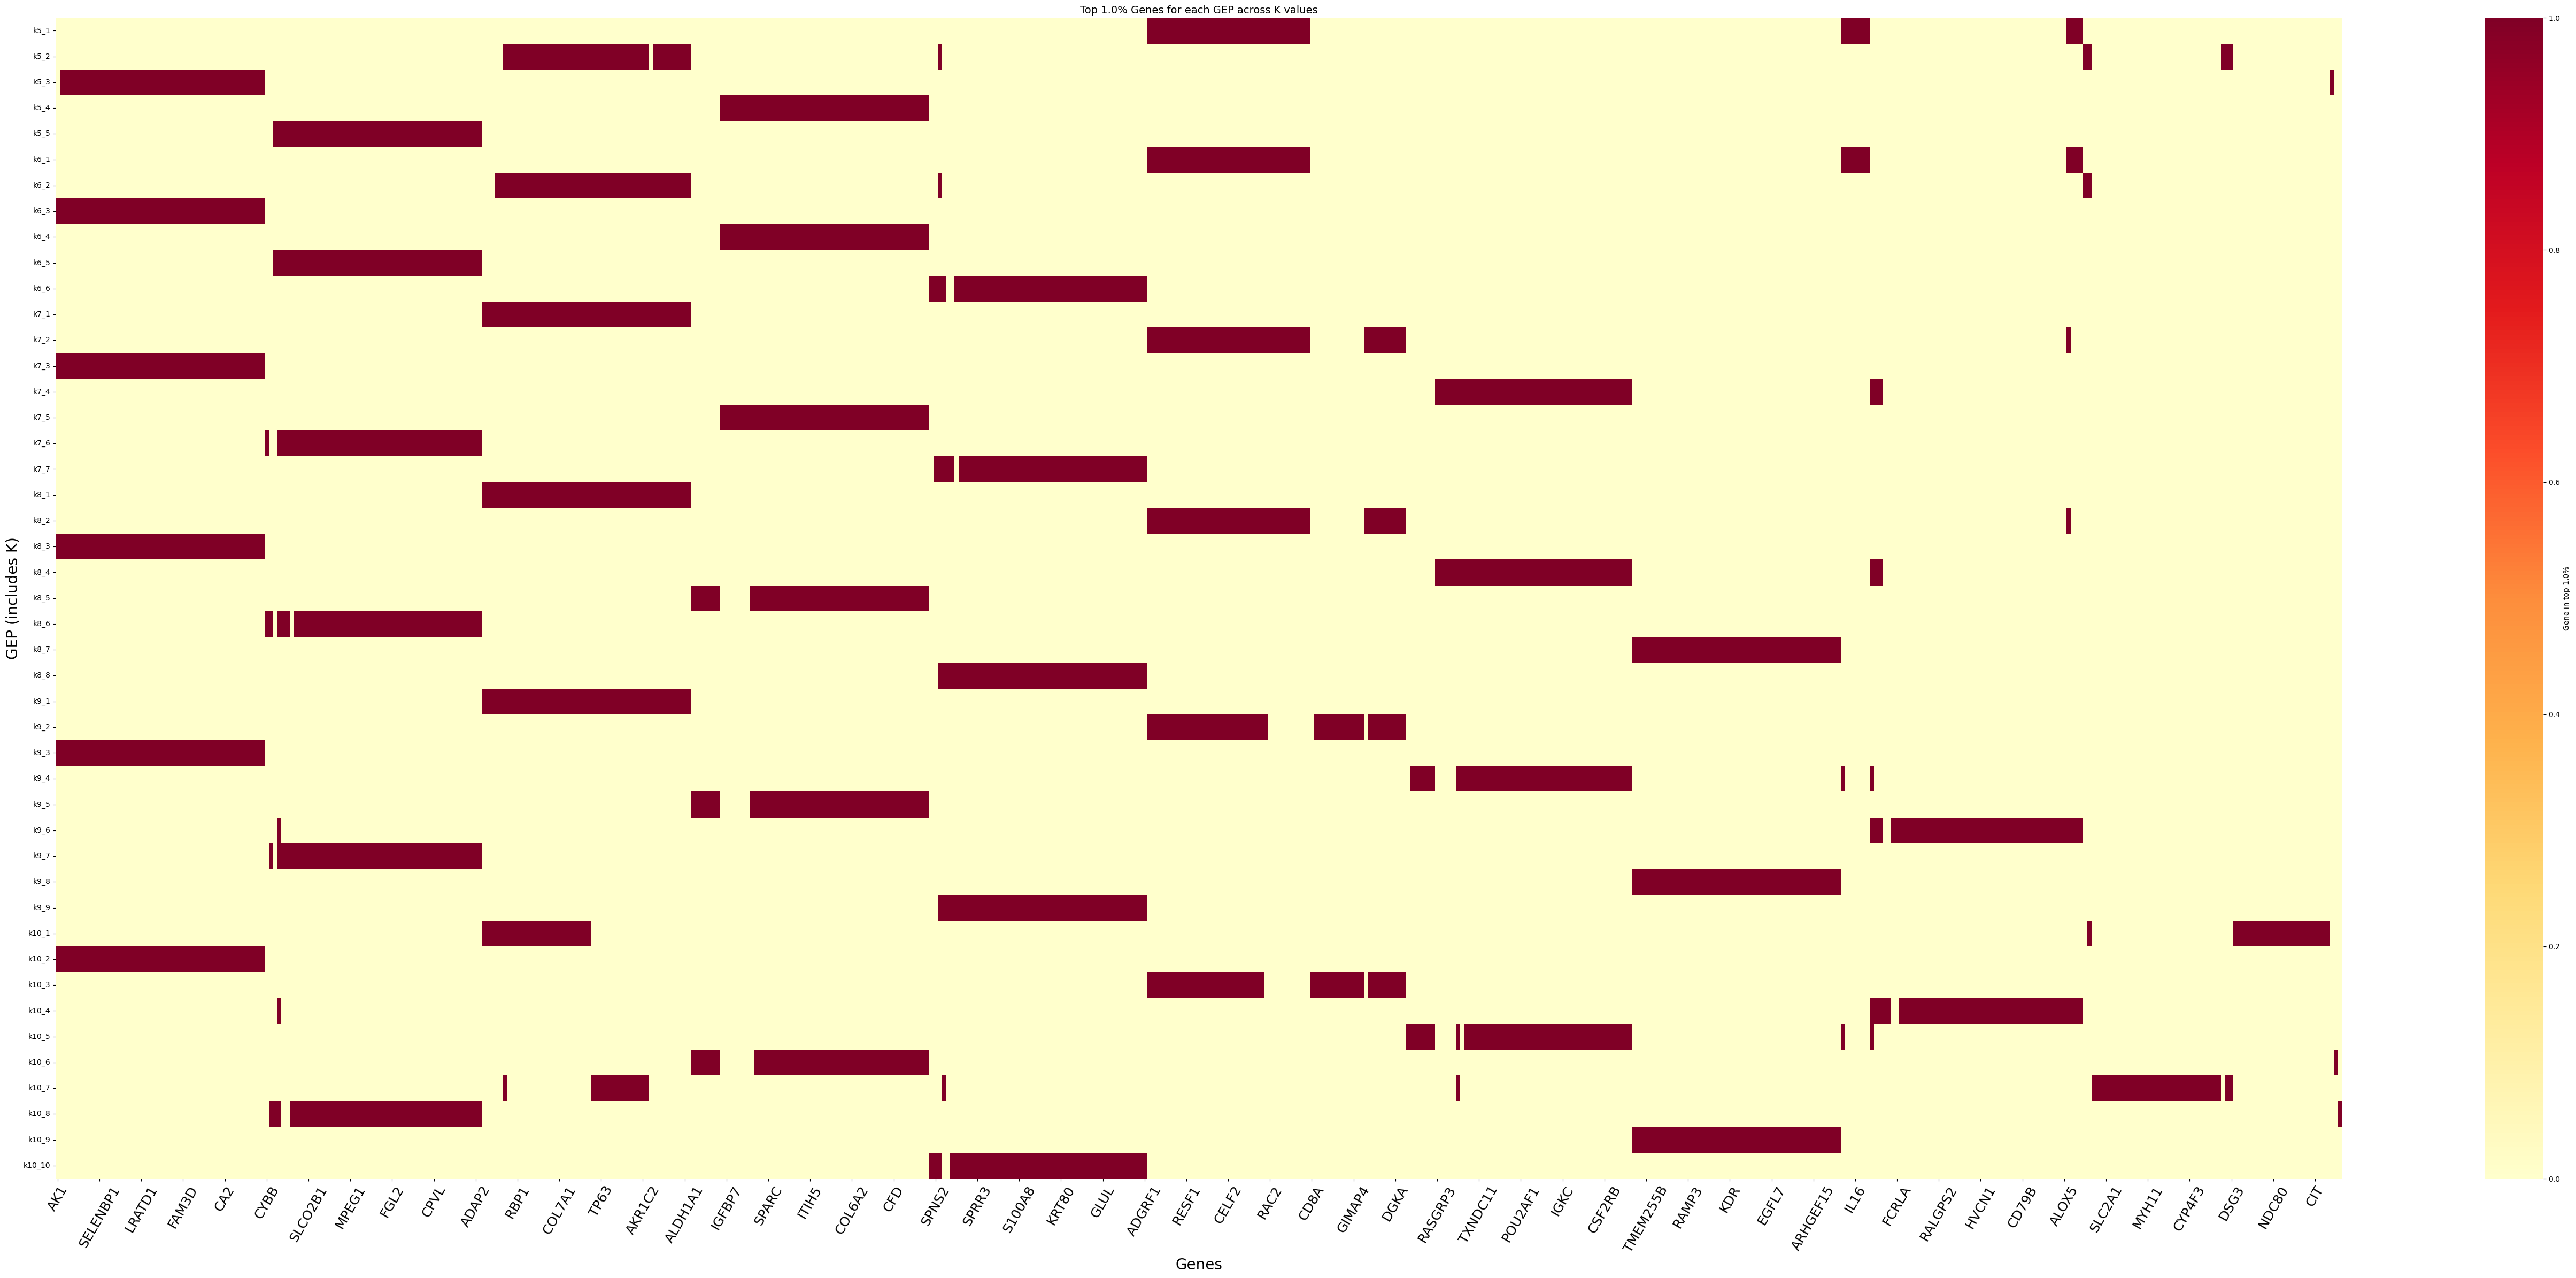

In [9]:
k_range = range(5, 11)
fig, matrix = plot_top_genes_across_k(
    'all_datasets_consensus/S1_spectra_vector_subset',
    'anal_pc5_c21_S1.filtered',
    k_range
)
plt.show()

In [4]:
def plot_spectra_heatmaps_per_k(output_dir, name, k_range, density_threshold=0.01, top_pct=0.01):
    """
    Create separate heatmaps for each K showing only the top genes
    for that K value.

    Expected input file format:
        - Rows = GEPs (e.g., k5_GEP1, k5_GEP2, ...)
        - Columns = genes
    """
    n_ks = len(k_range)
    n_cols = 3
    n_rows = int(np.ceil(n_ks / n_cols))
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(40, 4*n_rows))
    axes = axes.flatten()
    
    for idx, k in enumerate(k_range):

        # ---- Load spectra matrix for this K ----
        spectra_file = f"{output_dir}/{name}.gene_spectra_score.k_{k}.dt_{str(density_threshold).replace('.', '_')}.txt"
        spectra_df = pd.read_csv(spectra_file, sep='\t', index_col=0)

        # Number of genes available
        n_genes = spectra_df.shape[1]
        n_top_genes = max(1, int(n_genes * top_pct))

        # ---- Collect top genes for all GEPs (rows) ----
        top_genes_per_gep = []
        for gep_name, row in spectra_df.iterrows():
            top_genes = row.nlargest(n_top_genes).index
            top_genes_per_gep.extend(top_genes)

        # Unique set of top genes for this K
        unique_top_genes = sorted(set(top_genes_per_gep))

        # ---- Subset matrix to only top genes ----
        spectra_subset = spectra_df[unique_top_genes]

        # ---- Plot heatmap ----
        sns.heatmap(
            spectra_subset,
            cmap='viridis',
            ax=axes[idx],
            xticklabels=True,
            yticklabels=True,
            cbar=True
        )

        axes[idx].set_title(f"K = {k}")
        axes[idx].set_ylabel("GEP")
        axes[idx].set_xlabel(f"Top {top_pct*100:.1f}% genes")

        # Make x-axis labels smaller + rotated + spaced
        axes[idx].tick_params(axis='x', labelsize=6, rotation=90, pad=2)

    # ---- Hide unused subplot panels ----
    for idx in range(len(k_range), len(axes)):
        axes[idx].axis('off')

    plt.tight_layout()
    return fig

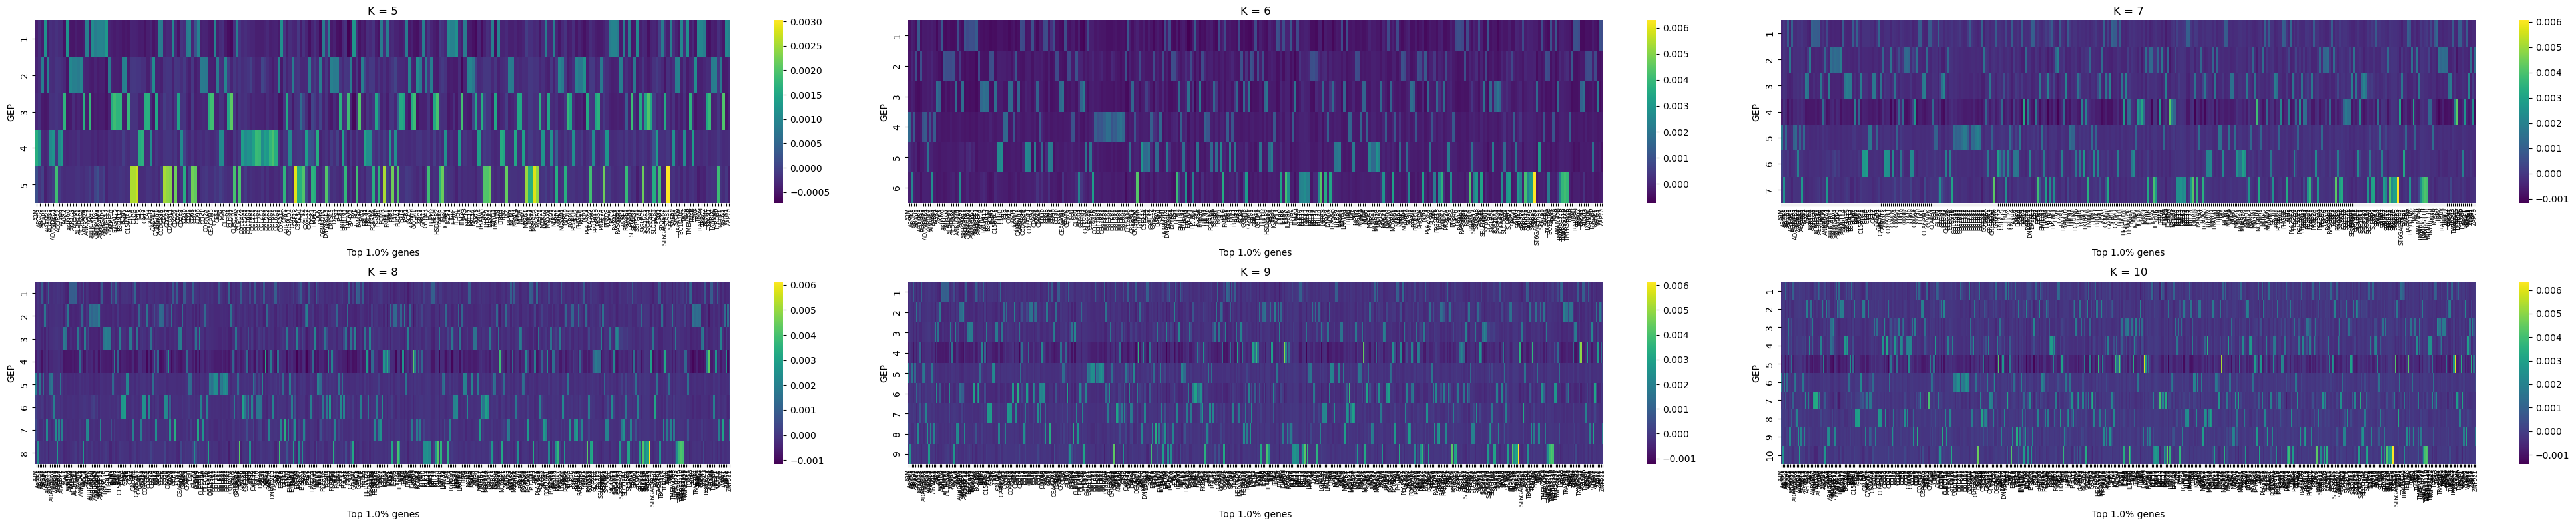

In [5]:
# Usage
fig = plot_spectra_heatmaps_per_k('all_datasets_consensus/S1_spectra_vector_subset', 'anal_pc5_c21_S1.filtered', range(5, 11))
plt.show()

## how often to genes show up across GEPs for a certain K value?

In [6]:
def plot_dotplot_genes_across_k(output_dir, name, k_range, density_threshold=0.01, top_pct=0.01):
    """
    Dot plot showing gene presence across different k values.
    Size/color = how many GEPs at that k contain the gene in the top %.
    """
    gene_counts_by_k = {}
    
    for k in k_range:
        spectra_file = f"{output_dir}/{name}.gene_spectra_score.k_{k}.dt_{str(density_threshold).replace('.', '_')}.txt"
        spectra_df = pd.read_csv(spectra_file, sep='\t', index_col=0)
        
        # Number of genes to keep (top X% of columns)
        n_genes = spectra_df.shape[1]
        n_top_genes = max(1, int(n_genes * top_pct))
        
        gene_counts = {}
        
        # Loop over each GEP (each row)
        for gep_name, row in spectra_df.iterrows():
            top_genes = row.nlargest(n_top_genes).index
            
            for gene in top_genes:
                gene_counts[gene] = gene_counts.get(gene, 0) + 1
        
        gene_counts_by_k[k] = gene_counts
    
    # Collect all genes
    all_genes = set()
    for counts in gene_counts_by_k.values():
        all_genes.update(counts.keys())
    
    # Build matrix: rows=genes, columns=K values
    dot_data = pd.DataFrame(0, index=sorted(all_genes), columns=k_range)
    for k, counts in gene_counts_by_k.items():
        for gene, count in counts.items():
            dot_data.loc[gene, k] = count
    
    # Keep most frequently occurring genes
    gene_appearance = dot_data.sum(axis=1)
    top_genes_to_plot = gene_appearance.nlargest(100).index
    
    dot_data_subset = dot_data.loc[top_genes_to_plot, :]
    
    # Plot
    fig, ax = plt.subplots(figsize=(12, 20))
    
    max_count = dot_data_subset.max().max()
    
    for i, gene in enumerate(dot_data_subset.index):
        for j, k in enumerate(k_range):
            count = dot_data_subset.loc[gene, k]
            if count > 0:
                ax.scatter(j, i, s=count*50, c=count,
                           cmap='Reds', vmin=0, vmax=max_count,
                           edgecolors='black', linewidth=0.5)
    
    ax.set_xticks(range(len(k_range)))
    ax.set_xticklabels(k_range)
    ax.set_yticks(range(len(top_genes_to_plot)))
    ax.set_yticklabels(top_genes_to_plot, fontsize=6)
    
    ax.set_xlabel("K value", fontsize=12)
    ax.set_ylabel("Genes", fontsize=12)
    ax.set_title("Gene appearance in top % across K values\n(size = # of GEPs)", fontsize=14)
    ax.grid(True, alpha=0.3)
    
    # Colorbar
    sm = plt.cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=0, vmax=max_count))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label("Number of GEPs", rotation=270, labelpad=20)
    
    plt.tight_layout()
    return fig, dot_data


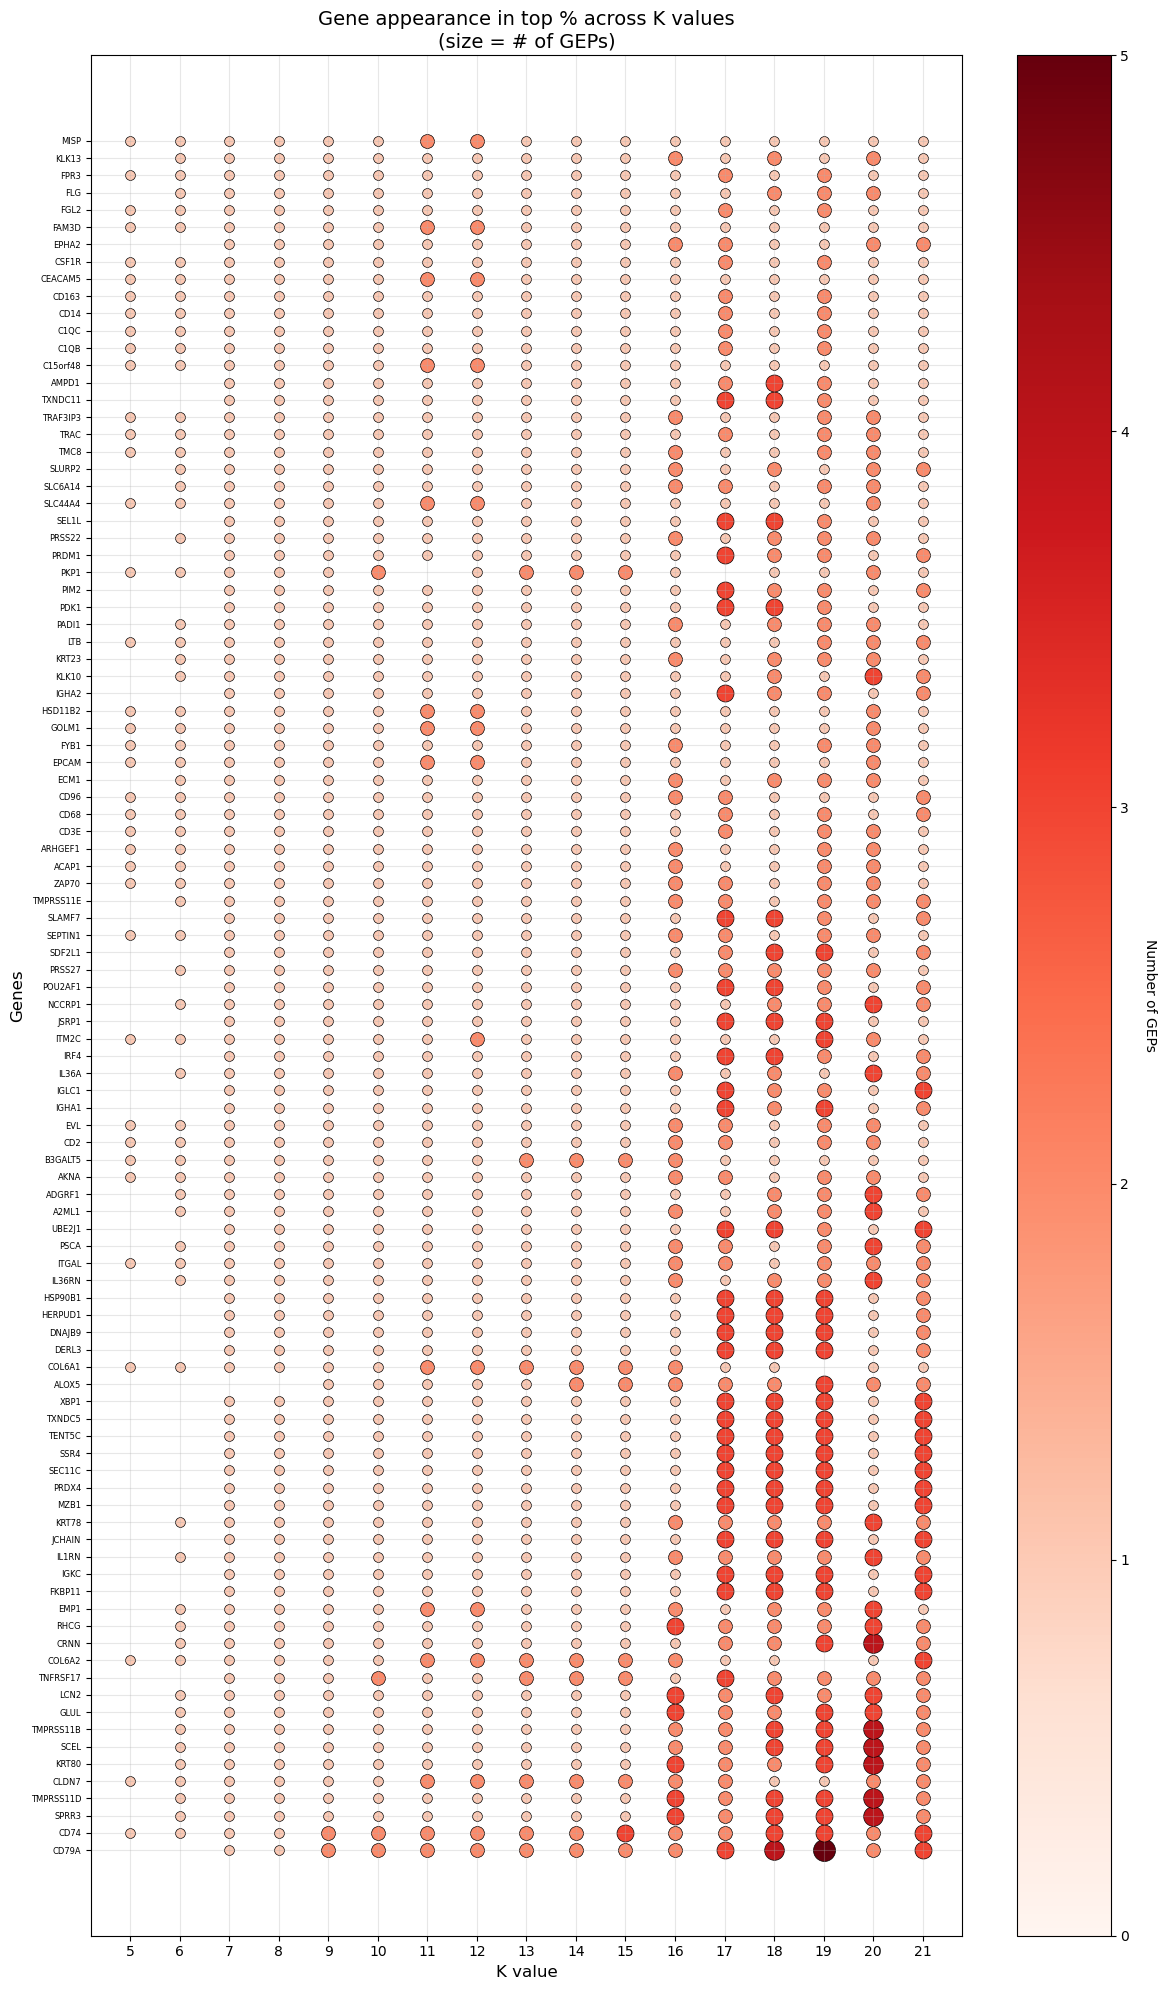

In [7]:
fig, data = plot_dotplot_genes_across_k(
    'all_datasets_consensus/anal_pc5_c21_S1.filtered_consensus_outputs',
    'anal_pc5_c21_S1.filtered',
    range(5, 22)
)
plt.show()


In [8]:
def plot_gene_persistence(output_dir, name, k_range, density_threshold=0.01, top_pct=0.01):
    """
    Count how many K values each gene appears in the top % of GEPs.
    Produces a histogram of how persistent genes are across K values.
    """
    gene_k_appearances = {}
    
    for k in k_range:
        # Fixed path (same as other functions)
        spectra_file = f"{output_dir}/{name}.gene_spectra_score.k_{k}.dt_{str(density_threshold).replace('.', '_')}.txt"
        spectra_df = pd.read_csv(spectra_file, sep='\t', index_col=0)
        
        # Number of top genes per GEP (top % of columns)
        n_genes = spectra_df.shape[1]
        n_top_genes = max(1, int(n_genes * top_pct))
        
        # Collect ALL top genes across GEPs for this K
        all_top_genes_this_k = set()
        
        for gep_name, row in spectra_df.iterrows():   # iterate rows (GEPs)
            top_genes = row.nlargest(n_top_genes).index
            all_top_genes_this_k.update(top_genes)
        
        # Record which K each gene appears in
        for gene in all_top_genes_this_k:
            if gene not in gene_k_appearances:
                gene_k_appearances[gene] = []
            gene_k_appearances[gene].append(k)
    
    # Count appearances for histogram
    appearance_counts = {gene: len(ks) for gene, ks in gene_k_appearances.items()}
    counts = pd.Series(appearance_counts)
    
    # Plot histogram
    fig, ax = plt.subplots(figsize=(12, 6))
    counts.value_counts().sort_index().plot(kind='bar', ax=ax, color='steelblue')
    
    ax.set_xlabel('Number of K values in which gene appears in top %', fontsize=12)
    ax.set_ylabel('Number of genes', fontsize=12)
    ax.set_title('Gene persistence across K values', fontsize=14)
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    return fig, counts

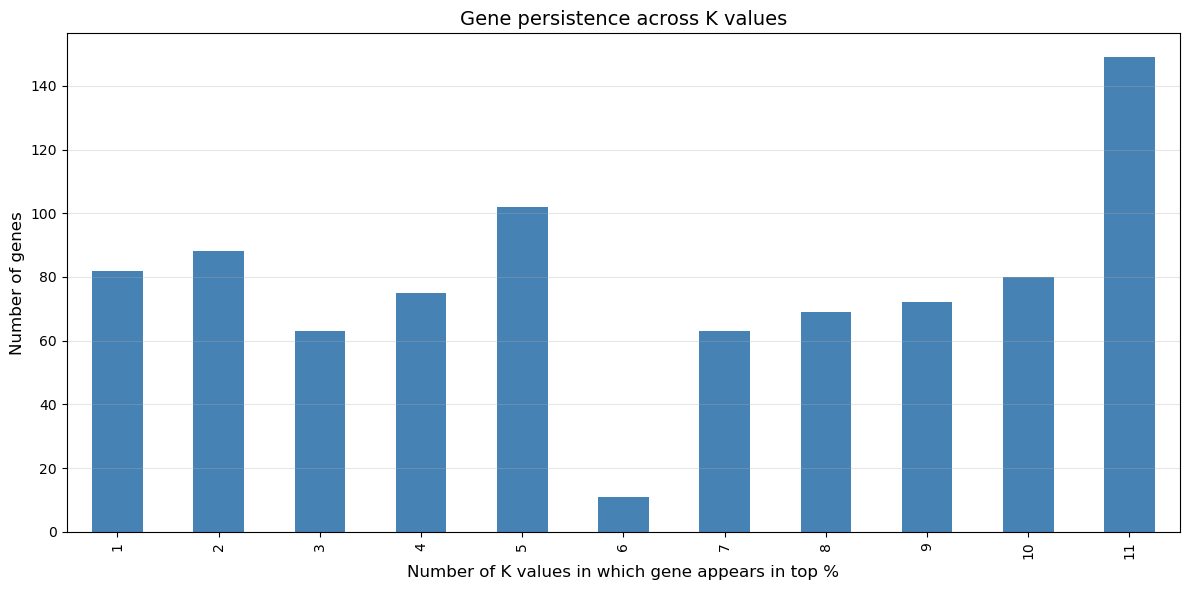

In [9]:
fig, counts = plot_gene_persistence(
    'all_datasets_consensus/anal_pc5_c21_S1.filtered_consensus_outputs',
    'anal_pc5_c21_S1.filtered',
    range(5, 16)
)
plt.show()


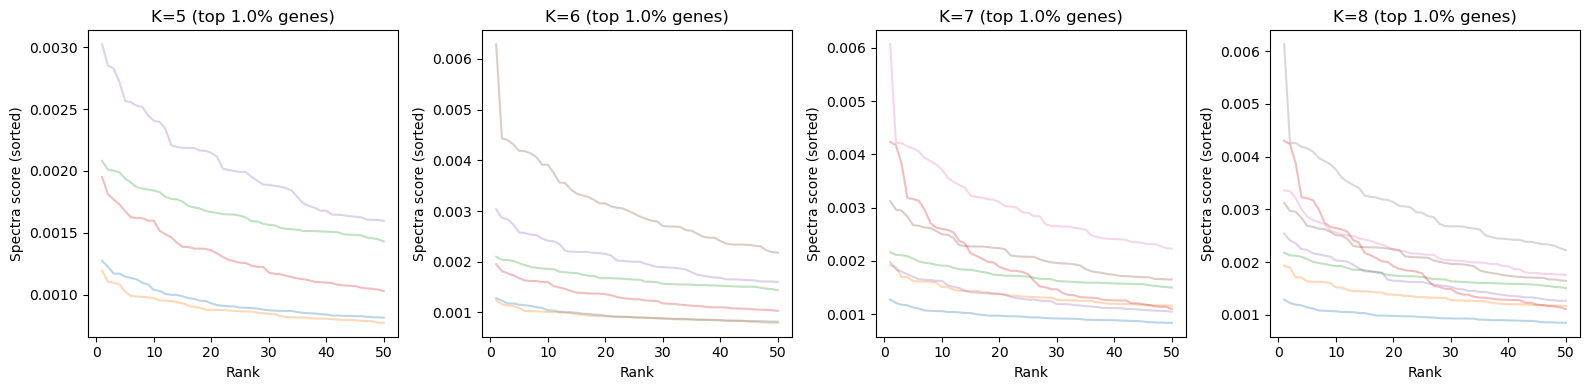

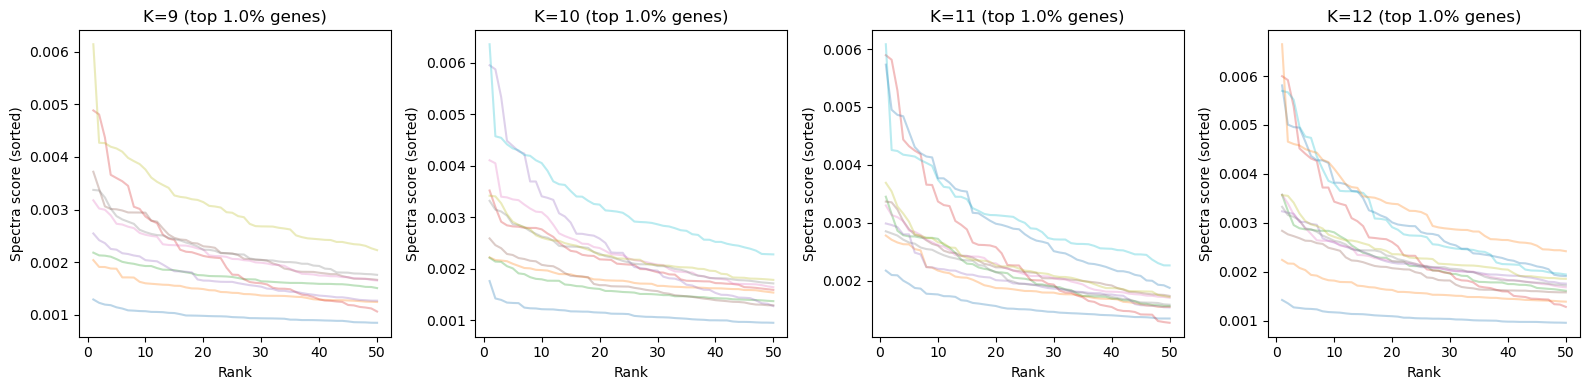

In [12]:
def load_spectra_files(parent_dir, name_prefix, ks):
    """Load gene_spectra_score matrices into a dict[K] -> DataFrame."""
    spectra = {}
    for k in ks:
        pattern = os.path.join(
            parent_dir,
            f"{name_prefix}.gene_spectra_score.k_{k}.*.txt"  # matches dt_0_01 etc.
        )
        files = glob.glob(pattern)
        if not files:
            print(f"No file found for K={k} with pattern {pattern}")
            continue
        fn = files[0]
        df = pd.read_csv(fn, sep="\t", index_col=0)
        spectra[k] = df
    return spectra

def plot_ranked_spectra_top_frac(spectra_dict, top_frac=0.01, max_k_per_fig=4):
    """
    spectra_dict: {K: DataFrame(K x G)}
    top_frac: fraction of genes to keep (e.g., 0.01 for top 1%)
    """
    ks = sorted(spectra_dict.keys())
    n_figs = int(np.ceil(len(ks) / max_k_per_fig))

    for fig_i in range(n_figs):
        fig_ks = ks[fig_i * max_k_per_fig:(fig_i+1) * max_k_per_fig]
        n_cols = len(fig_ks)
        plt.figure(figsize=(4 * n_cols, 4))

        for i, k in enumerate(fig_ks, 1):
            df = spectra_dict[k]
            n_genes = df.shape[1]
            top_n = max(1, int(np.ceil(top_frac * n_genes)))

            ax = plt.subplot(1, n_cols, i)
            for gep_idx in range(df.shape[0]):
                scores = df.iloc[gep_idx].values
                scores_sorted = np.sort(scores)[::-1]
                ax.plot(range(1, top_n + 1),
                        scores_sorted[:top_n],
                        alpha=0.3)

            ax.set_title(f"K={k} (top {top_frac*100:.1f}% genes)")
            ax.set_xlabel("Rank")
            ax.set_ylabel("Spectra score (sorted)")
        plt.tight_layout()
        plt.show()


parent_dir = "all_datasets_consensus/anal_pc5_c21_S1.filtered_consensus_outputs"
name_prefix = "anal_pc5_c21_S1.filtered"
ks = range(5, 13)
spectra = load_spectra_files(parent_dir, name_prefix, ks)
plot_ranked_spectra_top_frac(spectra, top_frac=0.01)

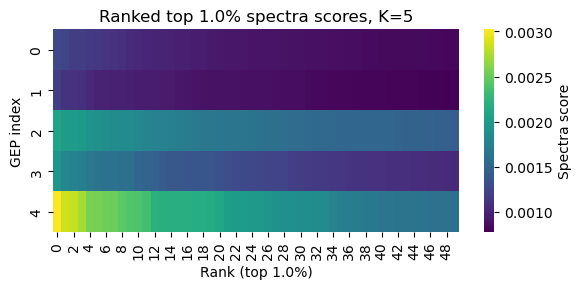

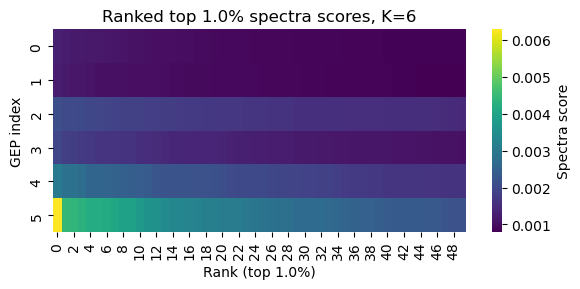

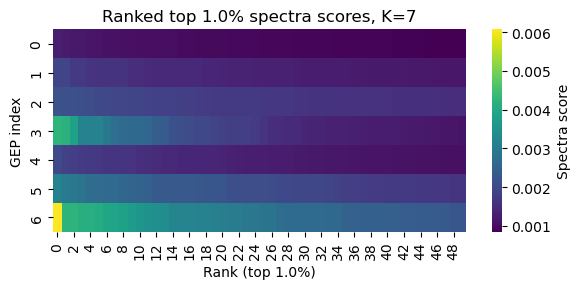

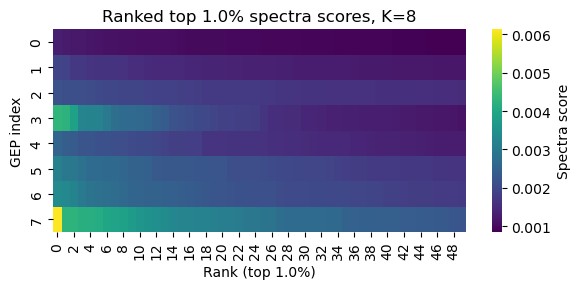

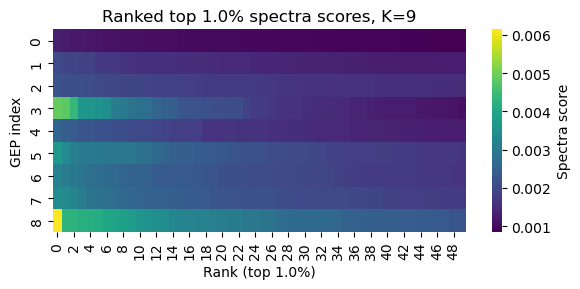

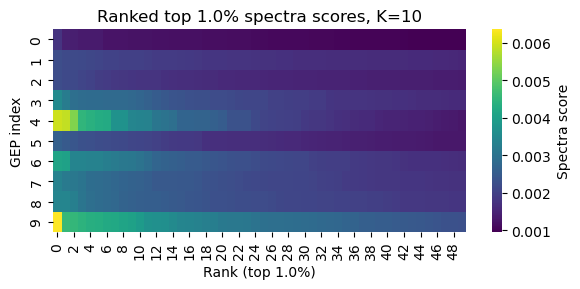

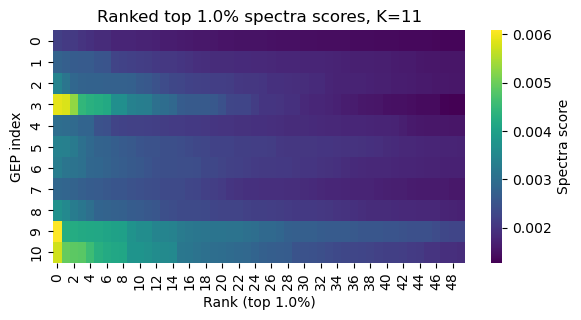

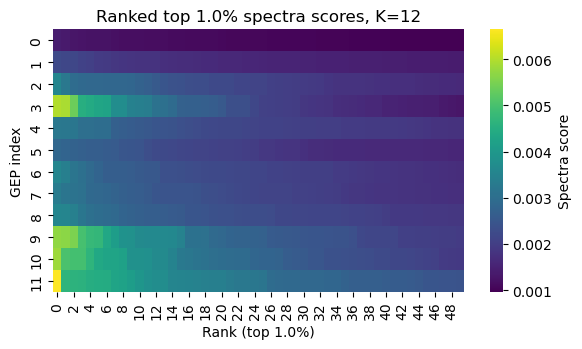

In [13]:
def build_ranked_matrix(df, top_frac=0.01):
    """
    df: K x G DataFrame (GEPs x genes).
    Returns: (K x top_n) numpy array of sorted top scores for each GEP.
    """
    n_genes = df.shape[1]
    top_n = max(1, int(np.ceil(top_frac * n_genes)))
    ranked = []
    for gep_idx in range(df.shape[0]):
        s = df.iloc[gep_idx].values
        s_sorted = np.sort(s)[::-1]
        ranked.append(s_sorted[:top_n])
    return np.vstack(ranked)

def plot_ranked_heatmap_for_k(spectra_dict, k, top_frac=0.01):
    df = spectra_dict[k]
    ranked = build_ranked_matrix(df, top_frac=top_frac)

    plt.figure(figsize=(6, max(3, df.shape[0] * 0.3)))
    sns.heatmap(ranked,
                cmap="viridis",
                cbar_kws={"label": "Spectra score"})
    plt.xlabel("Rank (top {:.1f}%)".format(top_frac * 100))
    plt.ylabel("GEP index")
    plt.title(f"Ranked top {top_frac*100:.1f}% spectra scores, K={k}")
    plt.tight_layout()
    plt.show()

parent_dir = "all_datasets_consensus/anal_pc5_c21_S1.filtered_consensus_outputs"
name_prefix = "anal_pc5_c21_S1.filtered"
ks = range(5, 13)
spectra = load_spectra_files(parent_dir, name_prefix, ks)
for k in spectra.keys():
    plot_ranked_heatmap_for_k(spectra, k, top_frac=0.01)

In [5]:
def load_gene_spectra_scores(results_dir: str, name: str) -> Dict[int, pd.DataFrame]:
    """
    Load all gene_spectra_score files from a cNMF results directory.
    
    Parameters
    ----------
    results_dir : str
        Path to the cNMF output directory containing the named subdirectory
    name : str
        Name of the cNMF run (used in filenames)
    
    Returns
    -------
    dict : {k_value: DataFrame} where DataFrame has GEPs as rows, genes as columns
    """
    # Look for gene_spectra_score files
    # Pattern: {name}.gene_spectra_score.k_{k}.dt_{density}.txt
    search_path = os.path.join(results_dir, f"{name}.gene_spectra_score.k_*.dt_*.txt")
    files = glob.glob(search_path)
    
    
    if not files:
        raise FileNotFoundError(f"No gene_spectra_score files found in {results_dir}/{name}/")
    
    spectra_dict = {}
    for f in files:
        # Extract k value from filename
        match = re.search(r'\.k_(\d+)\.', os.path.basename(f))
        if match:
            k = int(match.group(1))
            df = pd.read_csv(f, sep='\t', index_col=0)
            spectra_dict[k] = df
            print(f"Loaded K={k}: {df.shape[0]} GEPs × {df.shape[1]} genes")
    
    return dict(sorted(spectra_dict.items()))


def get_top_genes_per_gep(spectra_df: pd.DataFrame, 
                          top_percent: float = 1.0) -> Dict[str, pd.DataFrame]:
    """
    Get top genes for each GEP based on percentile ranking.
    
    Parameters
    ----------
    spectra_df : DataFrame
        GEPs (rows) × genes (columns) matrix of spectra scores
    top_percent : float
        Top percentage of genes to select (default 1%)
    
    Returns
    -------
    dict : {gep_name: DataFrame with columns ['gene', 'score', 'rank']}
    """
    n_top = max(1, int(spectra_df.shape[1] * top_percent / 100))
    
    top_genes = {}
    for gep in spectra_df.index:
        scores = spectra_df.loc[gep].sort_values(ascending=False)
        top = scores.head(n_top)
        top_genes[gep] = pd.DataFrame({
            'gene': top.index,
            'score': top.values,
            'rank': range(1, len(top) + 1)
        })
    
    return top_genes, n_top

In [9]:
def plot_gene_gene_clustermap(spectra_dict: Dict[int, pd.DataFrame],
                               top_percent: float = 1.0,
                               k_value: Optional[int] = None,
                               method: str = 'average',
                               metric: str = 'correlation'):
    """
    Create a gene-gene correlation clustermap based on their GEP scores.
    This shows which genes have similar patterns across GEPs.
    """
    if k_value is not None:
        # Use single K
        spectra_df = spectra_dict[k_value]
        title_suffix = f'K={k_value}'
    else:
        # Combine all K values
        combined_dfs = []
        for k, df in spectra_dict.items():
            df_copy = df.copy()
            df_copy.index = [f'K{k}_{idx}' for idx in df_copy.index]
            combined_dfs.append(df_copy)
        spectra_df = pd.concat(combined_dfs, axis=0)
        title_suffix = f'All K (K={min(spectra_dict.keys())}-{max(spectra_dict.keys())})'
    
    # Get top genes
    all_top_genes = set()
    for k, df in spectra_dict.items():
        top_genes_dict, _ = get_top_genes_per_gep(df, top_percent)
        for gep, gene_df in top_genes_dict.items():
            all_top_genes.update(gene_df['gene'].tolist())
    all_top_genes = sorted(all_top_genes)
    
    # Subset and transpose: now genes are rows, GEPs are columns
    subset_df = spectra_df[all_top_genes].T
    
    # Compute gene-gene correlation
    gene_corr = subset_df.T.corr()
    
    # Figure size
    n_genes = len(all_top_genes)
    fig_size = max(10, n_genes * 0.08 + 2)
    
    # Create clustermap
    g = sns.clustermap(
        gene_corr,
        method=method,
        metric='euclidean',  # Use euclidean on correlation matrix
        cmap='viridis',
        vmin=-1,
        vmax=1,
        center=0,
        figsize=(fig_size, fig_size),
        dendrogram_ratio=0.12,
        cbar_pos=(0.02, 0.8, 0.03, 0.15),
        xticklabels=True,
        yticklabels=True,
        linewidths=0,
        tree_kws={'linewidths': 1.0}
    )
    
    g.ax_heatmap.tick_params(axis='x', labelsize=5, rotation=90)
    g.ax_heatmap.tick_params(axis='y', labelsize=5)
    
    g.fig.suptitle(
        f'Gene-Gene Correlation Clustermap ({title_suffix})\n'
        f'Top {top_percent}% genes ({n_genes} genes) | Correlation of GEP score patterns',
        y=1.02, fontsize=11
    )
    
    return g

Loaded K=9: 9 GEPs × 5000 genes
Loaded K=6: 6 GEPs × 5000 genes
Loaded K=7: 7 GEPs × 5000 genes
Loaded K=10: 10 GEPs × 5000 genes
Loaded K=5: 5 GEPs × 5000 genes
Loaded K=8: 8 GEPs × 5000 genes


/home/hdlab/miniconda3/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/hdlab/miniconda3/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


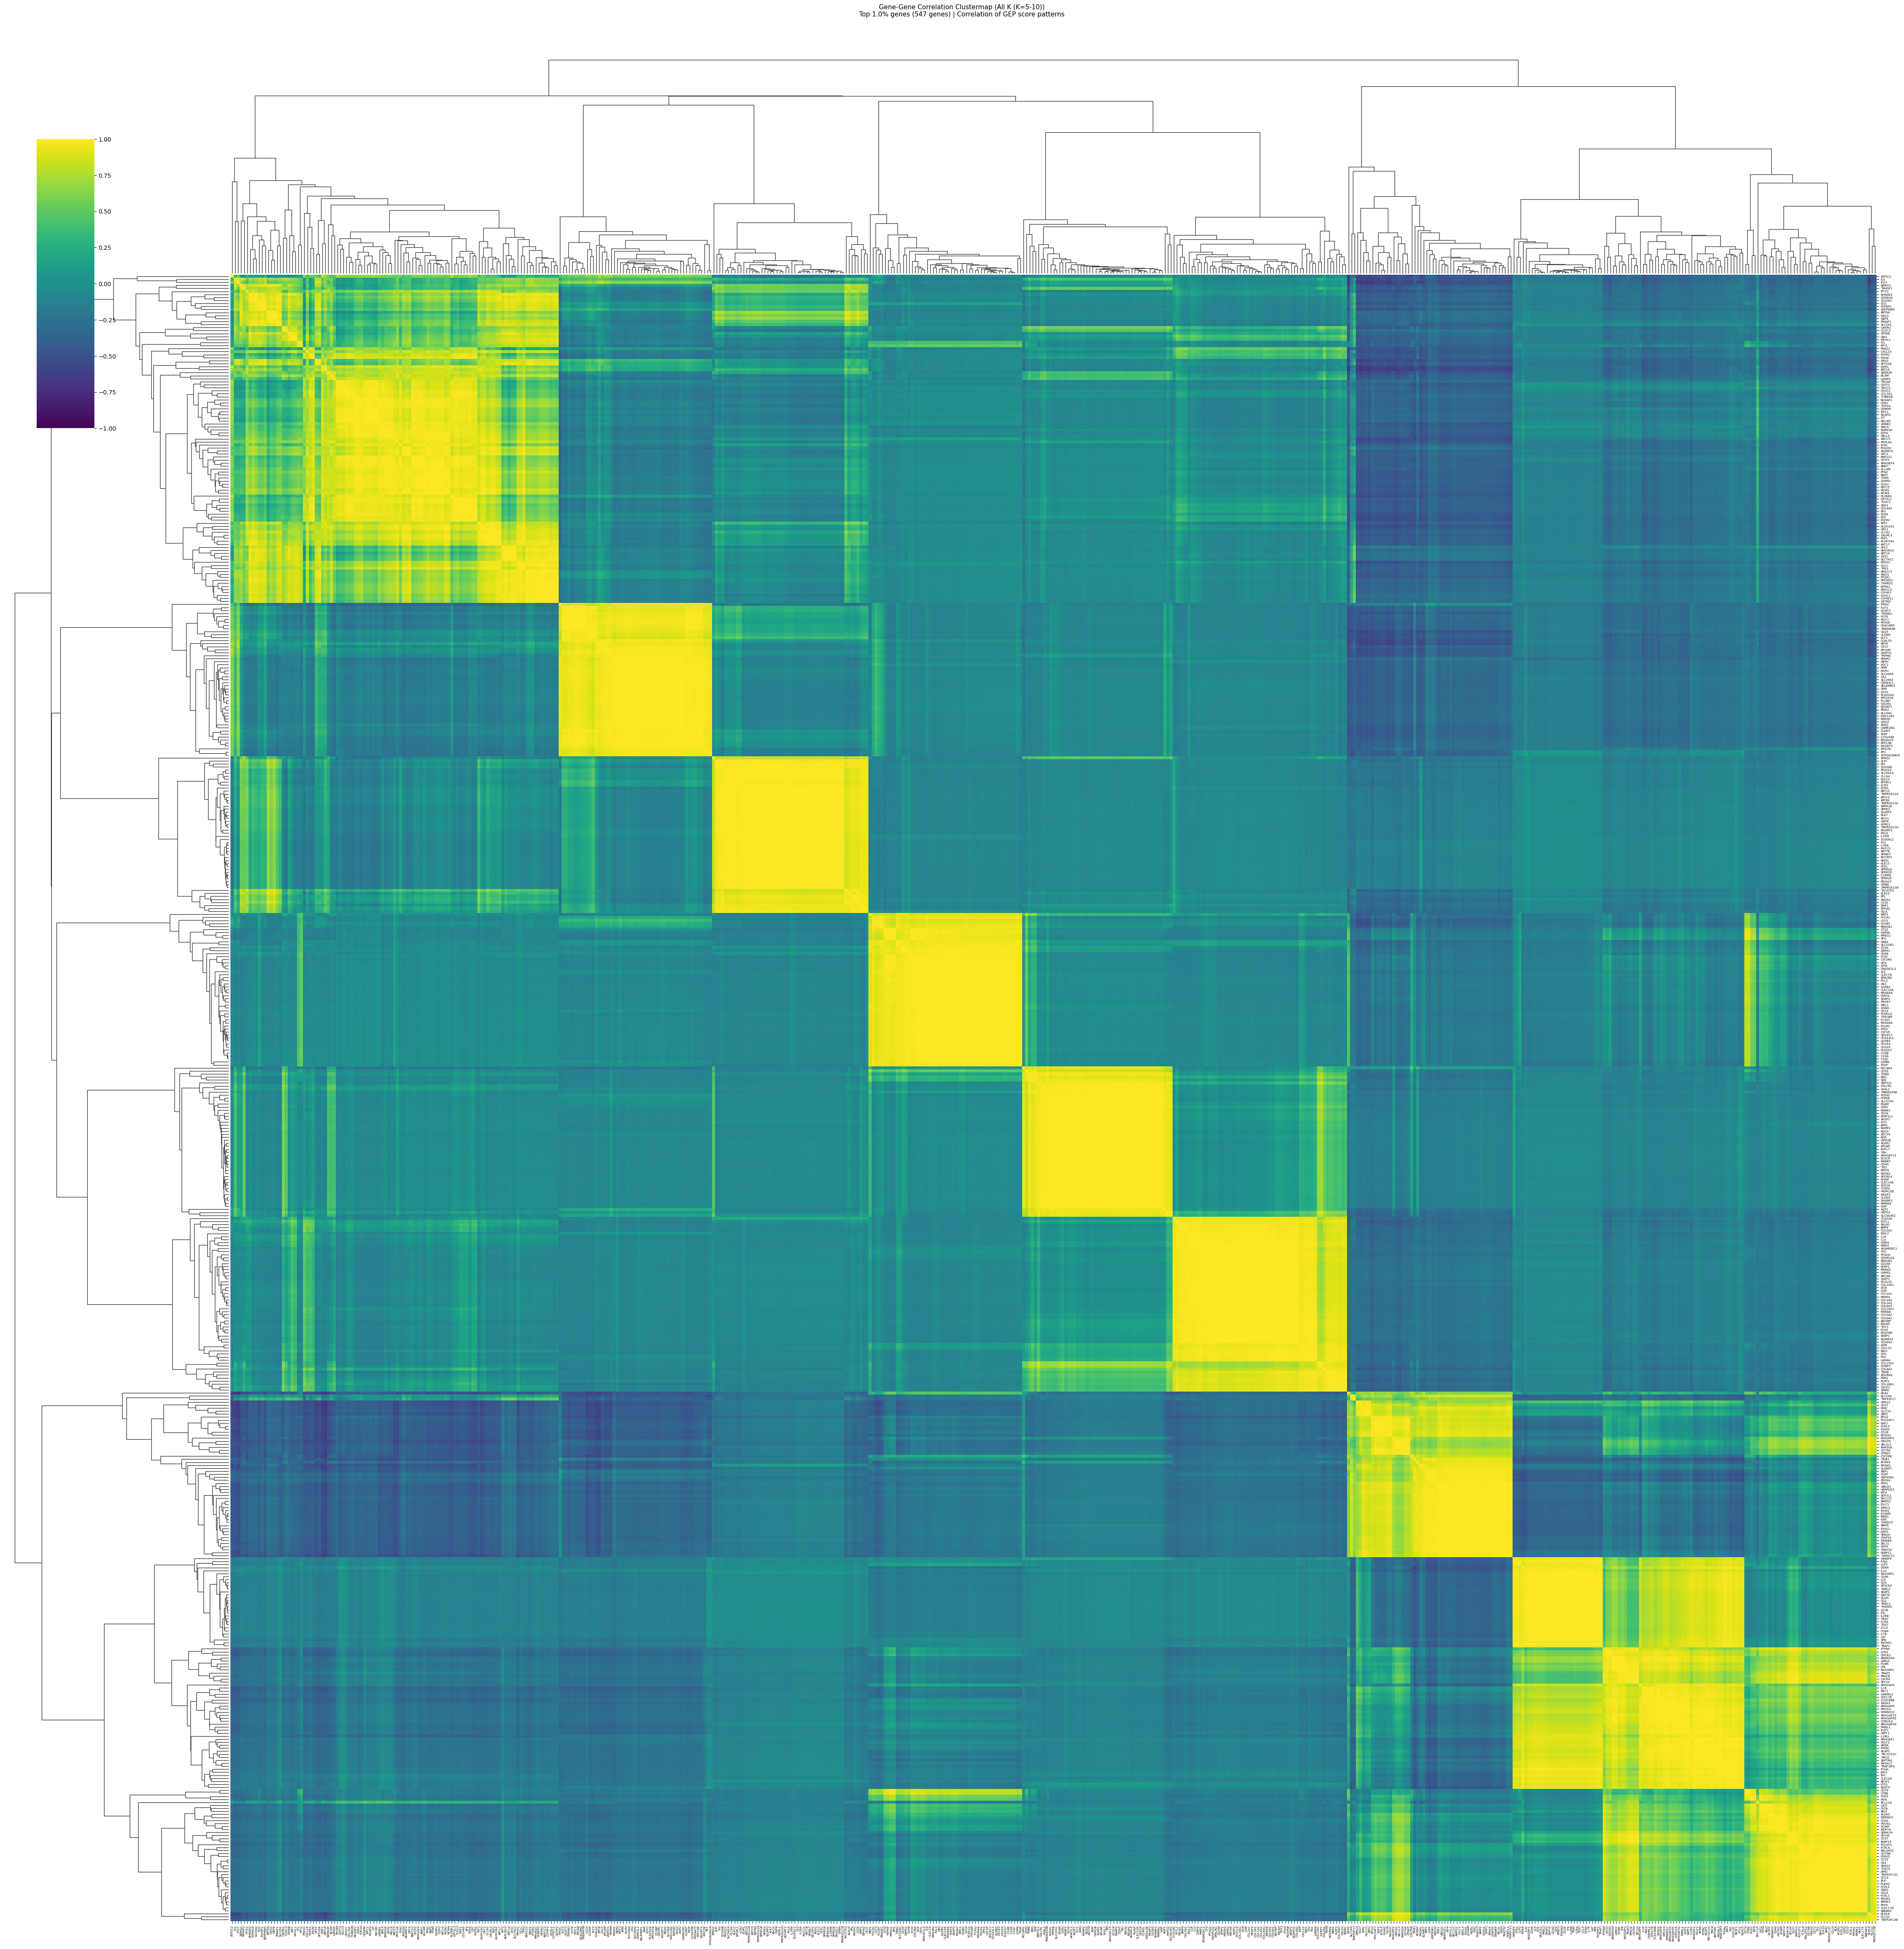

In [10]:
spectra_dict = load_gene_spectra_scores('all_datasets_consensus/S1_spectra_vector_subset', 'anal_pc5_c21_S1.filtered')
plot = plot_gene_gene_clustermap(spectra_dict, top_percent=1.0, k_value=None)

In [15]:
def plot_combined_clustermap(spectra_dict: Dict[int, pd.DataFrame],
                              top_percent: float = 1.0,
                              method: str = 'ward',
                              metric: str = 'euclidean',
                              cmap: str = 'RdBu_r') -> sns.matrix.ClusterGrid:
    """
    Create a single hierarchically clustered heatmap combining all K values.
    Rows are labeled as K{k}_GEP{i}.
    """
    # Combine all spectra into one DataFrame with K-prefixed row names
    combined_dfs = []
    k_labels = []
    
    for k, spectra_df in spectra_dict.items():
        df_copy = spectra_df.copy()
        # Rename index to include K value
        df_copy.index = [f'K{k}_{idx}' for idx in df_copy.index]
        combined_dfs.append(df_copy)
        k_labels.extend([k] * len(df_copy))
    
    combined_df = pd.concat(combined_dfs, axis=0)
    
    # Get top genes across all GEPs from all K values
    all_top_genes = set()
    for k, spectra_df in spectra_dict.items():
        top_genes_dict, _ = get_top_genes_per_gep(spectra_df, top_percent)
        for gep, df in top_genes_dict.items():
            all_top_genes.update(df['gene'].tolist())
    all_top_genes = sorted(all_top_genes)
    
    # Subset to top genes
    subset_df = combined_df[all_top_genes].copy()
    
    # Create color palette for K values
    unique_k = sorted(spectra_dict.keys())
    k_palette = dict(zip(unique_k, sns.color_palette('husl', len(unique_k))))
    row_colors = pd.Series(k_labels, index=subset_df.index).map(k_palette)
    row_colors.name = 'K value'
    
    # Figure size
    n_genes = len(all_top_genes)
    n_geps = subset_df.shape[0]
    fig_width = max(14, n_genes * 0.1 + 4)
    fig_height = max(10, n_geps * 0.15 + 3)
    
    # Center at 0
    vmax = np.abs(subset_df.values).max()
    
    # Create clustermap with row colors
    g = sns.clustermap(
        subset_df,
        method=method,
        metric=metric,
        cmap=cmap,
        center=0,
        vmin=-vmax,
        vmax=vmax,
        row_colors=row_colors,
        figsize=(fig_width, fig_height),
        dendrogram_ratio=(0.1, 0.1),
        cbar_pos=(0.02, 0.8, 0.02, 0.12),
        xticklabels=True,
        yticklabels=True,
        linewidths=0.3,
        tree_kws={'linewidths': 1.0}
    )
    
    # Labels
    g.ax_heatmap.set_xlabel('Genes (hierarchically clustered)')
    g.ax_heatmap.set_ylabel('GEPs across K values (hierarchically clustered)')
    g.ax_heatmap.tick_params(axis='x', labelsize=5, rotation=90)
    g.ax_heatmap.tick_params(axis='y', labelsize=6)
    
    # Add legend for K values
    legend_handles = [Patch(facecolor=k_palette[k], label=f'K={k}') for k in unique_k]
    g.ax_heatmap.legend(
        handles=legend_handles, 
        loc='upper left', 
        bbox_to_anchor=(1.15, 1),
        title='K value',
        fontsize=8
    )
    
    g.fig.suptitle(
        f'Combined Hierarchical Clustering: All K Values (K={min(unique_k)}-{max(unique_k)})\n'
        f'Top {top_percent}% genes ({n_genes} unique) | {n_geps} total GEPs | method={method}',
        y=1.02, fontsize=15
    )
    
    return g

/home/hdlab/miniconda3/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/hdlab/miniconda3/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


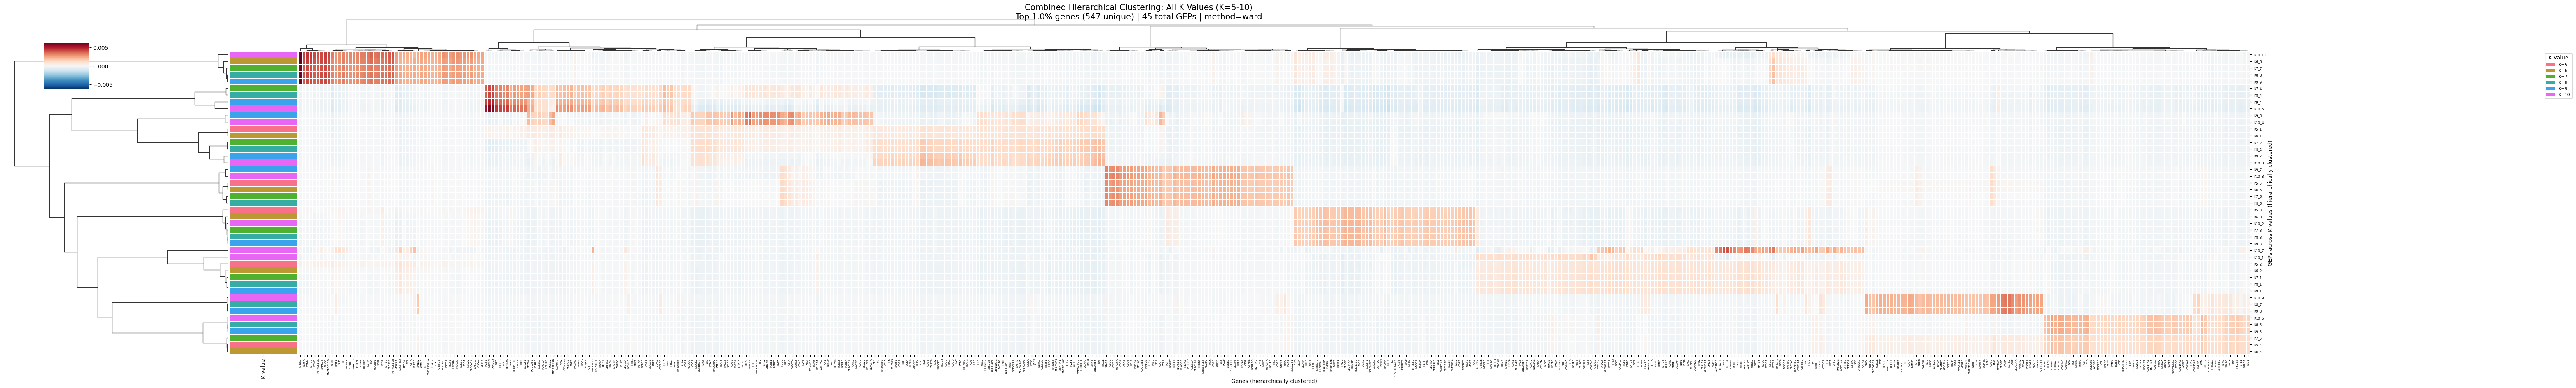

In [16]:
plot_combined_clustermap(spectra_dict, top_percent=1.0)

In [19]:
def plot_hierarchical_clustermap(spectra_dict: Dict[int, pd.DataFrame],
                                  top_percent: float = 1.0,
                                  method: str = 'ward',
                                  metric: str = 'euclidean',
                                  z_score: Optional[int] = None,
                                  cmap: str = 'RdBu_r') -> Dict[int, sns.matrix.ClusterGrid]:
    """
    Create hierarchically clustered heatmaps for each K value.
    """
    
    clustergrid_dict = {}
    
    for k, spectra_df in spectra_dict.items():
        # Get top genes for each GEP
        top_genes_dict, n_top = get_top_genes_per_gep(spectra_df, top_percent)
        
        # Collect unique top genes across all GEPs
        all_top_genes = set()
        for gep, df in top_genes_dict.items():
            all_top_genes.update(df['gene'].tolist())
        all_top_genes = sorted(all_top_genes)
        
        # Subset to top genes only
        subset_df = spectra_df[all_top_genes].copy()
        
        # Determine figure size
        n_genes = len(all_top_genes)
        n_geps = subset_df.shape[0]
        fig_width = max(10, n_genes * 0.12 + 3)
        fig_height = max(6, n_geps * 0.4 + 3)
        
        # Center colormap at 0
        vmax = np.abs(subset_df.values).max()
        
        # Create clustermap
        g = sns.clustermap(
            subset_df,
            method=method,
            metric=metric,
            z_score=z_score,
            cmap=cmap,
            center=0,
            vmin=-vmax,
            vmax=vmax,
            figsize=(fig_width, fig_height),
            dendrogram_ratio=(0.15, 0.15),
            cbar_pos=(0.02, 0.8, 0.03, 0.15),
            xticklabels=True,
            yticklabels=True,
            linewidths=0.5,
            tree_kws={'linewidths': 1.5}
        )
        
        # Adjust labels
        g.ax_heatmap.set_xlabel('Genes (hierarchically clustered)')
        g.ax_heatmap.set_ylabel('GEPs (hierarchically clustered)')
        g.ax_heatmap.tick_params(axis='x', labelsize=6, rotation=90)
        g.ax_heatmap.tick_params(axis='y', labelsize=8)
        
        # Title
        g.fig.suptitle(
            f'K={k}: Hierarchical Clustering of Top {top_percent}% Genes\n'
            f'({n_top} genes/GEP, {n_genes} unique genes | method={method}, metric={metric})',
            y=1.02, fontsize=12
        )
        
        clustergrid_dict[k] = g
        
    return clustergrid_dict

{5: <seaborn.matrix.ClusterGrid at 0x7dbbe5e59590>,
 6: <seaborn.matrix.ClusterGrid at 0x7dbbe5aac390>,
 7: <seaborn.matrix.ClusterGrid at 0x7dbbe55fadd0>,
 8: <seaborn.matrix.ClusterGrid at 0x7dbbe670c6d0>,
 9: <seaborn.matrix.ClusterGrid at 0x7dbbe66e5110>,
 10: <seaborn.matrix.ClusterGrid at 0x7dbbd2f1a410>}

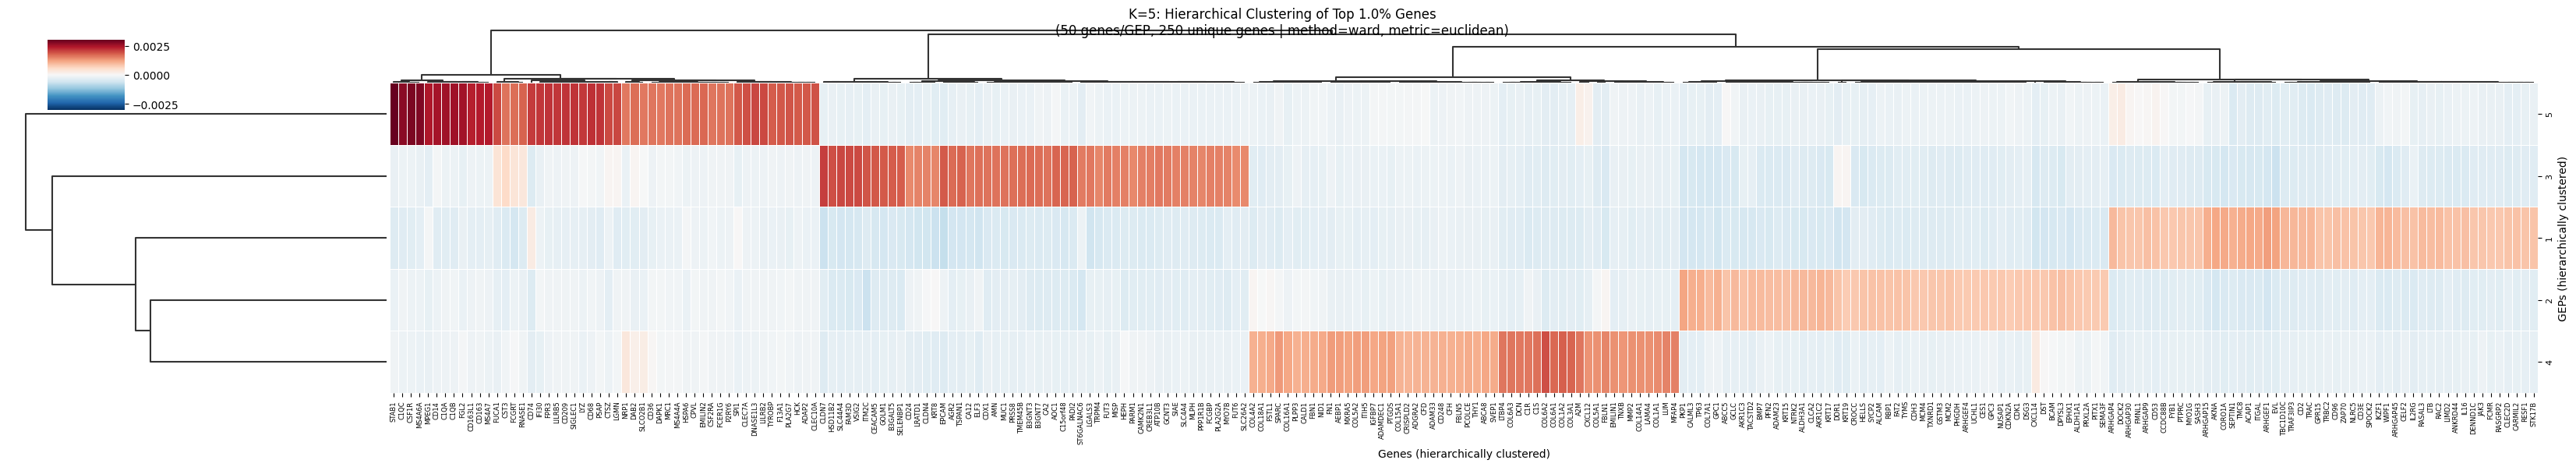

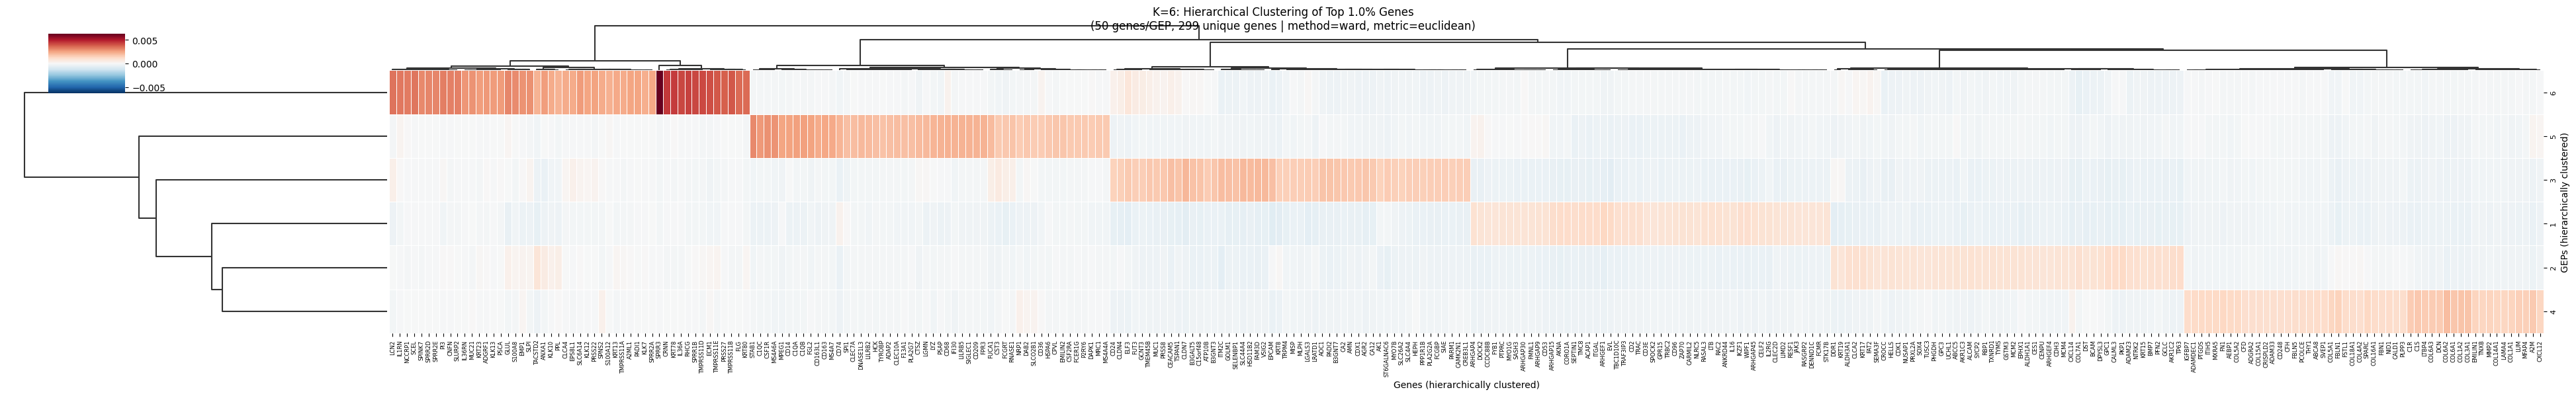

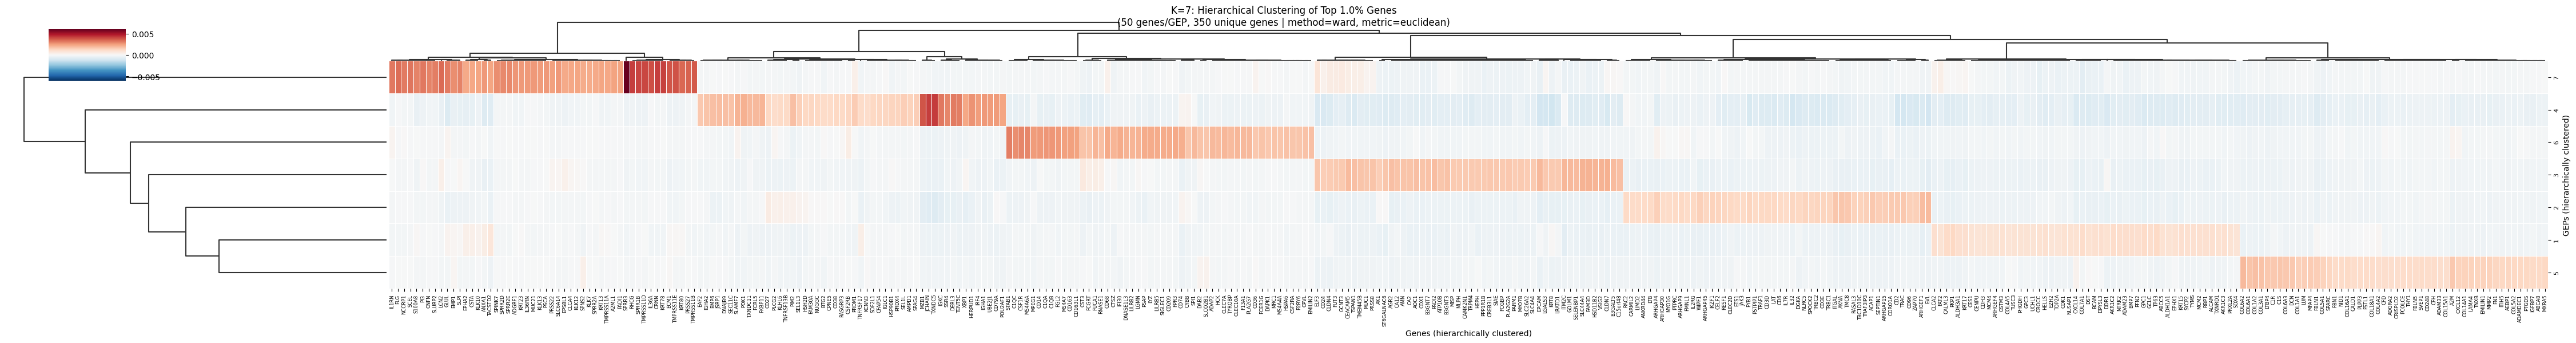

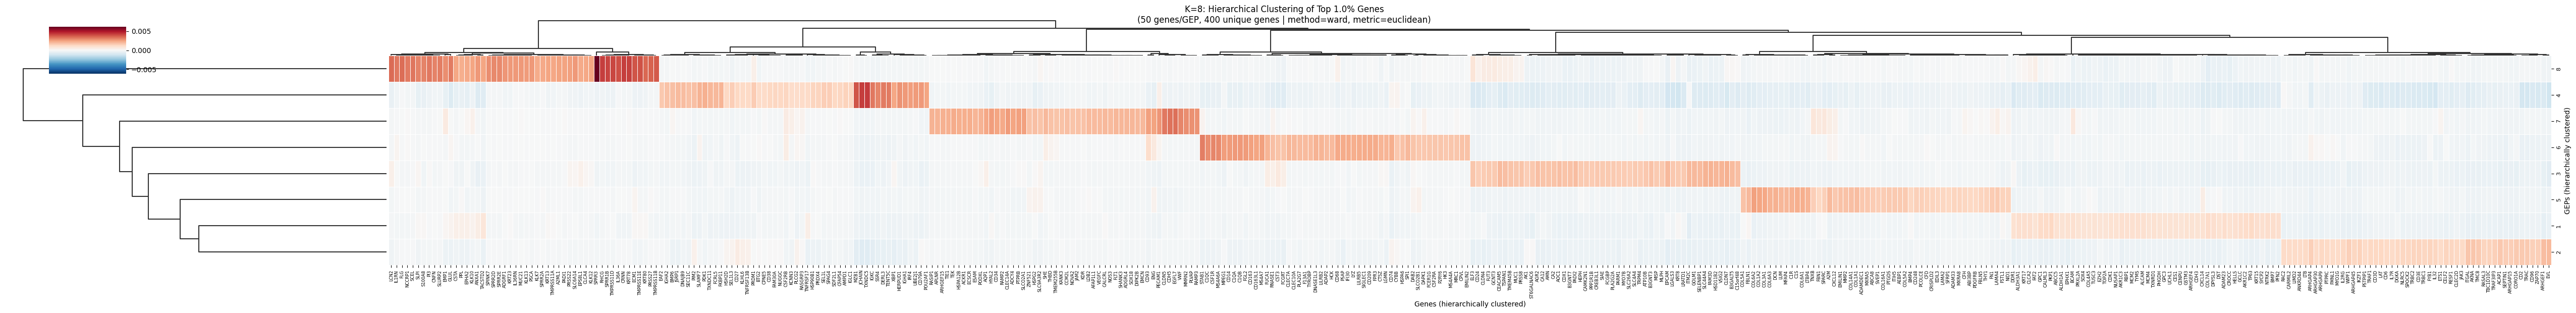

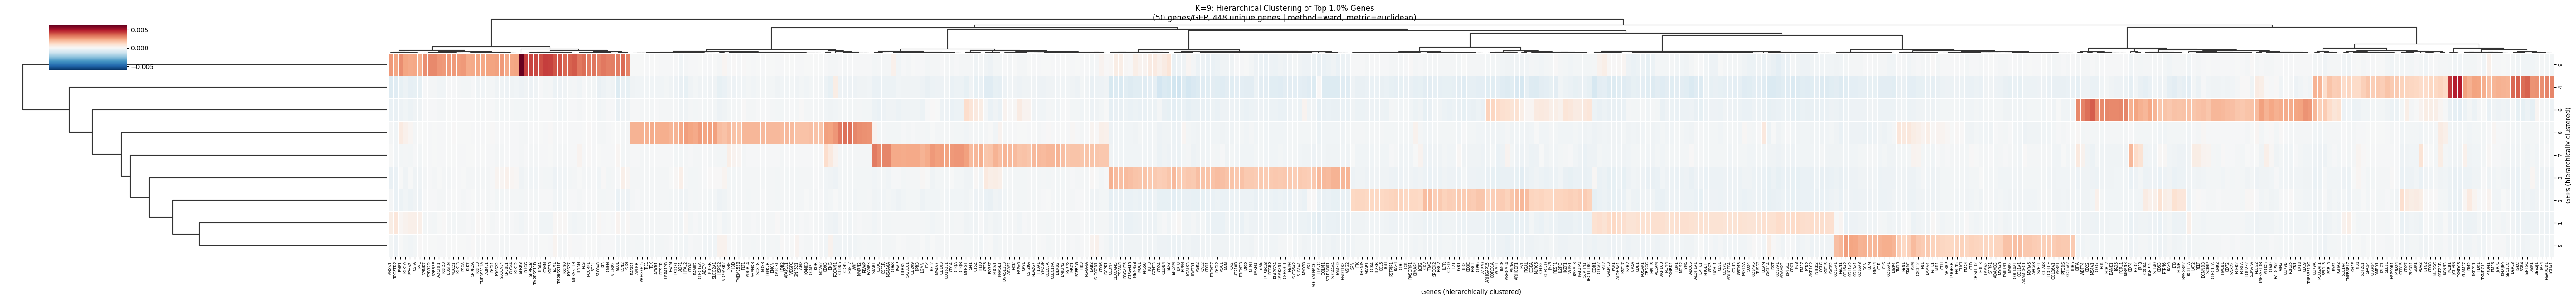

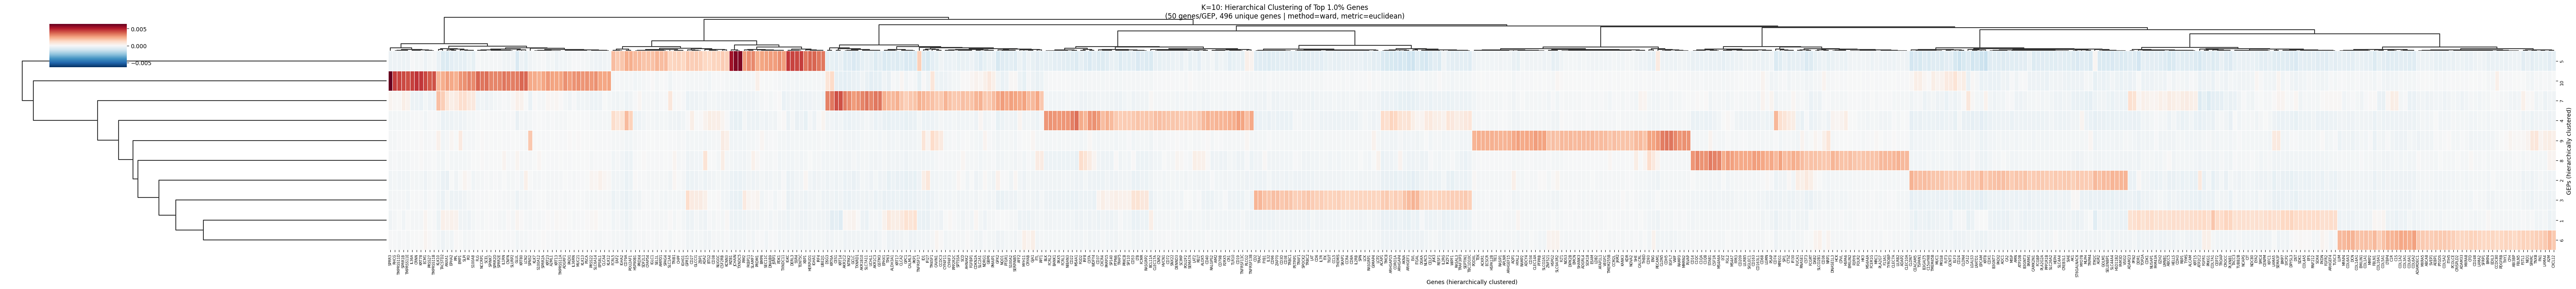

In [21]:
plot_hierarchical_clustermap(spectra_dict, top_percent=1.0, 
                              method='ward', metric='euclidean')
